# Using the PyWST package

This 'tutorial' notebook introduces the basic functionalities of *PyWST*, a Python package devised to perform WST/RWST analyses of astrophysical data.

Here we mainly give technical details so that you can easily compute and show WST/RWST statistics for your data. This complements more fundamental descriptions of what WST/RWST analyses allow you to do and that are introduced in:
* [Allys et al., 2019](https://arxiv.org/abs/1905.01372) for intensity maps of the diffuse interstellar medium
* [Regaldo-Saint Blancard et al., 2020](https://arxiv.org/abs/2007.08242) for polarization maps of the diffuse interstellar medium

## 0. Presentation of the test maps

Throughout this notebook we use 3 $I$ maps (real-valued) and one $\tilde{Q}+i\tilde{U}$ map (complex-valued) that correspond to simulated Stokes maps of the diffuse interstellar medium and that are introduced in **Regaldo-Saint Blancard+2020**. These maps serve as examples only, and we will not discuss what they describe.

Let us first load a few basic packages.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
import os
import sys

We now load the *PyWST* package in the following cell.

In [2]:
sys.path.insert(0, os.path.abspath('..')) # Note that this line is useless with a regular pip installation of PyWST.
import pywst as pw

We load our test maps in *mapsI* and *mapQiU* variables.

In [3]:
mapsI = []
mapsI.append (fits.open('data/I_1.fits')[0].data)
mapsI.append (fits.open('data/I_2.fits')[0].data)
mapsI.append (fits.open('data/I_3.fits')[0].data)
mapsI = np.array(mapsI)

mapQiU = fits.open('data/Q_1.fits')[0].data + 1j * fits.open('data/U_1.fits')[0].data

Let us now have a look on our data!

In [4]:
def plot_axis(fig, ax, data, title='', colorbar=True):
    im = ax.imshow (data, cmap='jet', vmin=data.mean()-3*data.std (), vmax=data.mean()+3*data.std())
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

<IPython.core.display.Javascript object>


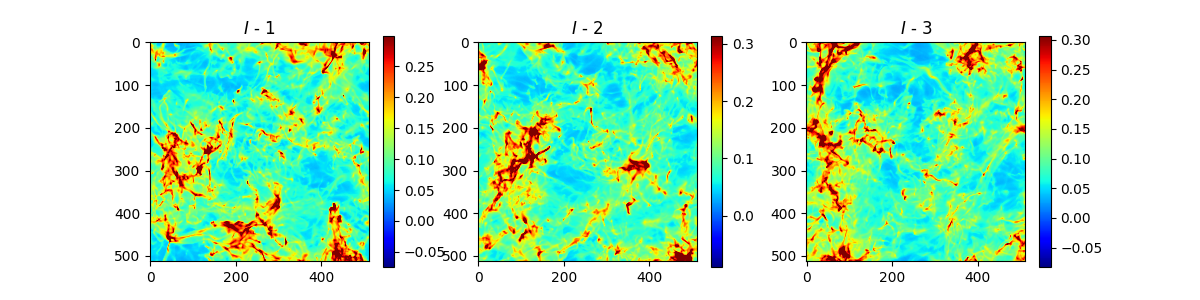

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plot_axis(fig, axs[0], mapsI[0], r"$I$ - 1")
plot_axis(fig, axs[1], mapsI[1], r"$I$ - 2")
plot_axis(fig, axs[2], mapsI[2], r"$I$ - 3")
plt.show()

<IPython.core.display.Javascript object>


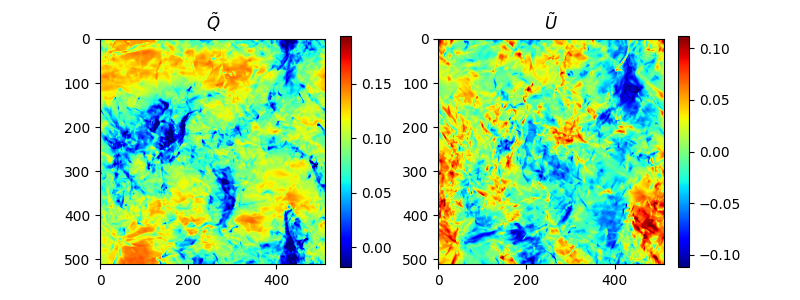

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plot_axis(fig, axs[0], mapQiU.real, r"$\tilde{Q}$")
plot_axis(fig, axs[1], mapQiU.imag, r"$\tilde{U}$")
plt.show()

We see that these maps are $512\times 512$ pixels maps and that they show periodic boundary conditions.

## 1. WST computation

In this section we show how to compute and plot WST coefficients for real and complex maps. These coefficients can be computed globally or locally on these maps, and we will give examples in both cases.

Before any WST/RWST analysis, we need to choose 3 important parameters:
* *J* parameter, which corresponds to the number of dyadic scales of the transform.
* *L* parameter, which corresponds to the number of angles in which the interval $[0,\pi]$ is divided. Note that this parameter corresponds to the $\Theta$ parameter in **Allys+2019** and **Regaldo-Saint Blancard+2020**.
* *OS* parameter, which stands for *OverSampling* parameter and helps us to control the resolution of the spatial sampling for local computations. Choosing values larger than 1 is not recommended without a specific knowledge of WST/RWST.

In [7]:
M, N = mapsI[0].shape # Height and width of the test maps
J = 7 # We choose to probe 7 scales
L = 8 # Number of angles in which the interval [0,pi] is divided
OS = 0 # No oversampling

**NB:** For technical reasons, the height and width of the input maps have to be multiples of $2^J$.

### 1.1. One real map, global WST

Let us first compute and show global WST coefficients for one real-valued $I$ map, namely:

$$
\begin{align}
	&S_0 = \langle I \rangle,\label{S0eqReal}\\
	&S_1(j_1,\theta_1) = \langle|I\star\psi_{j_1, \theta_1}|\rangle,\label{S1eqReal} &\text{ with } 0 \leq j_1 \leq J - 1 \text{ and } 0 \leq \theta_1 < L,\\
	&S_2 (j_1,\theta_1,j_2,\theta_2) = \langle ||I \star \psi_{j_1, \theta_1}|\star\psi_{j_2, \theta_2}|\rangle\label{S2eqReal}, &\text{ with } 0 \leq j_1,j_2 \leq J - 1 \text{ such that } j_2 > j_1 \text{ and } 0 \leq \theta_1,\theta_2 < L,
\end{align}
$$

To compute WST coefficients with *PyWST* we first need to define a WST operator, which is an instance of the *WSTOp* class. Building this operator can take a few tens of seconds (for typical parameters) as it also needs to build a corresponding bank of filters (wavelets and low-pass filters).

In [8]:
wst_op = pw.WSTOp(M, N, J, L, OS)

Once your operator is loaded, you can apply it easily to your data using the *apply* method.

In [9]:
wst = wst_op.apply(mapsI[0]) # Compute the WST of the first I map.

The output of the *apply* method is an instance of the *WST* class.

In [10]:
type(wst)

pywst.wst.WST

With such an object, we can easily manipulate the WST coefficients.

To begin, let us simply plot them:

<IPython.core.display.Javascript object>


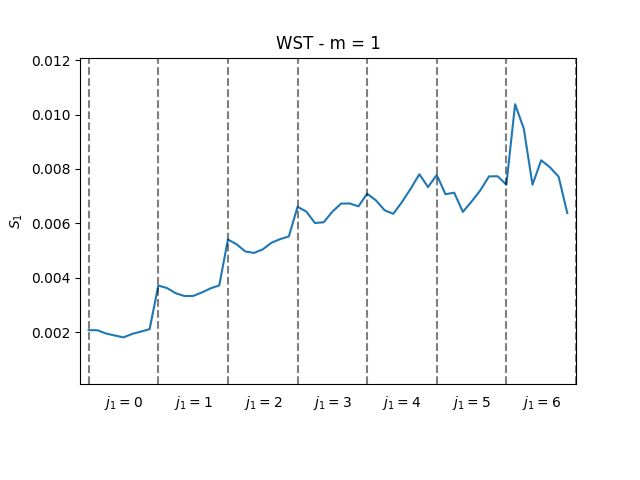

<IPython.core.display.Javascript object>


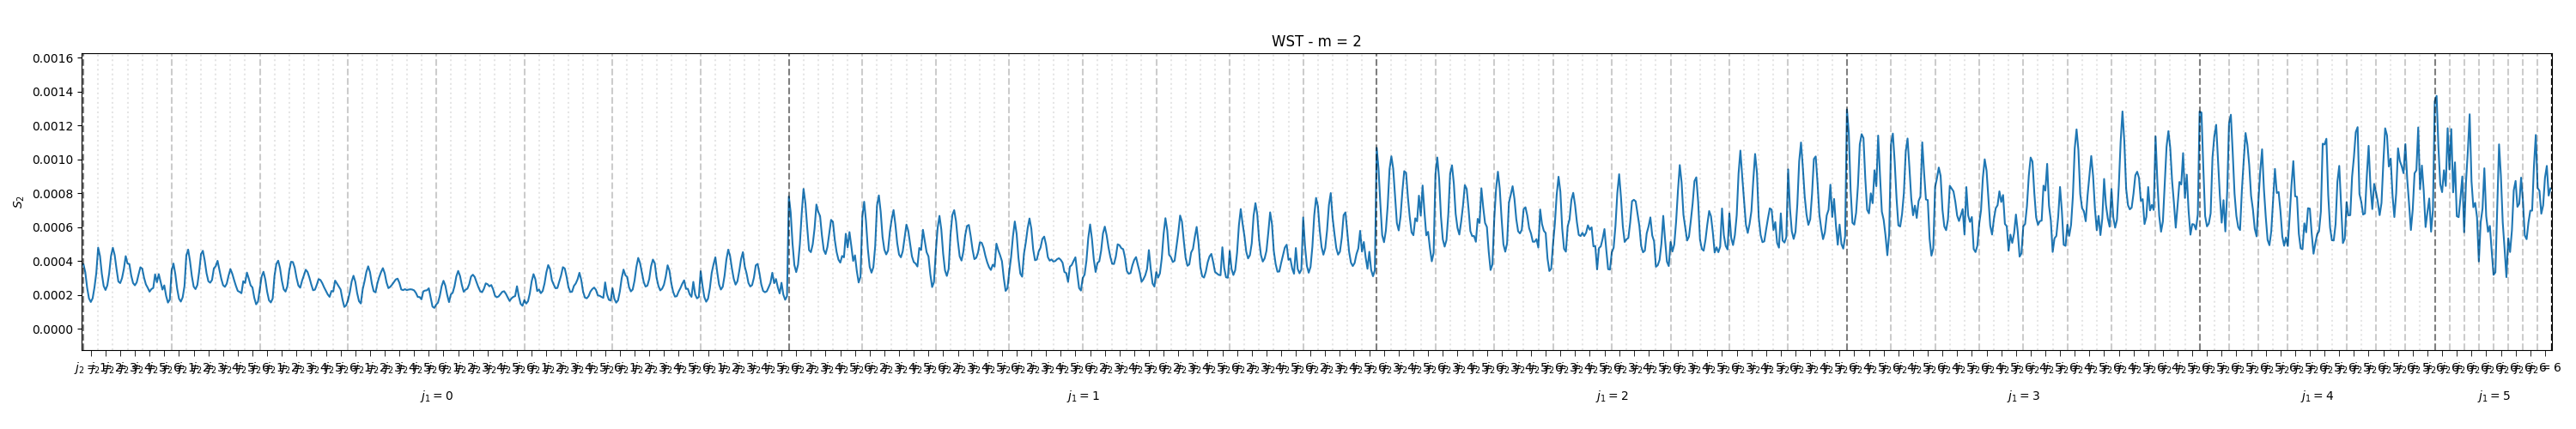

In [11]:
wst.plot()

Without any parameter, this *plot* method plots the WST coefficients of the first and second layers ($m=1$ and $m=2$). 
The coefficients are shown in a lexicographical order corresponding to $(j_1,\theta_1)$ variables for first order coefficients and $(j_1,\theta_1,j_2,\theta_2)$ variables for second order coefficients. The vertical dashed lines help to distinguish the increments of the variables.

We can also simply access the coefficients of a specific layer, or those corresponding to specific values of $(j_1,\theta_1,j_2,\theta_2)$ variables. For instance, in the following we get the coefficients of the first layer at the scale $j_1=2$ using the *get_coeffs* method.

In [12]:
coeffs, index = wst.get_coeffs(layer=1, j1=2)
print(coeffs)

[0.00540639 0.00523131 0.00496854 0.00491487 0.00504498 0.00528845
 0.00542174 0.00552155]


*get_coeffs* also returns the indices of the selected coefficients. They are presented in a matrix with 5 rows that respectively correspond to: $m$ (the layer index), $j_1$, $\theta_1$, $j_2$, $\theta_2$.

For our example, we have 8 columns, corresponding to the *L=8* possible values for $\theta_1$.

In [13]:
print(index.shape)
print(index)

(5, 8)
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [0. 1. 2. 3. 4. 5. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


It is usually more convenient to work with the logarithmic values of the coefficients. To do that, we use the *to_log2* method that computes the base 2 logarithm of the coefficients, to be consistent with dyadic scale indices $j_1$ and $j_2$.methods

<IPython.core.display.Javascript object>


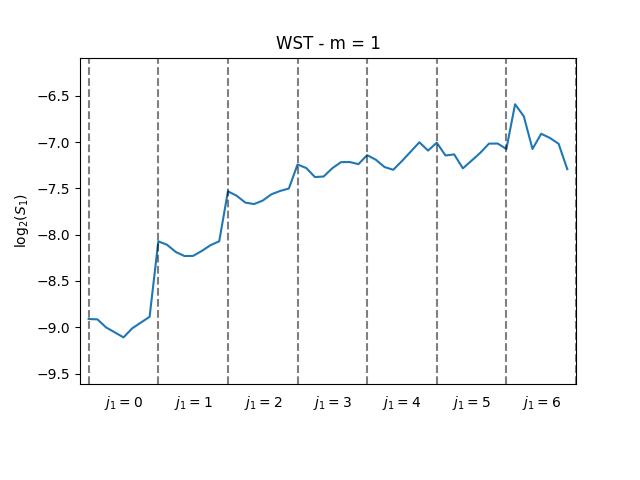

In [14]:
wst.to_log2()
wst.plot(layer=1)

The WST coefficients can be normalized using the *normalize* method. This normalizes $m=1$ coefficients with the $m=0$ one, and the $m=2$ coefficients with the $m=1$ coefficients.

[-3.1542283]


<IPython.core.display.Javascript object>


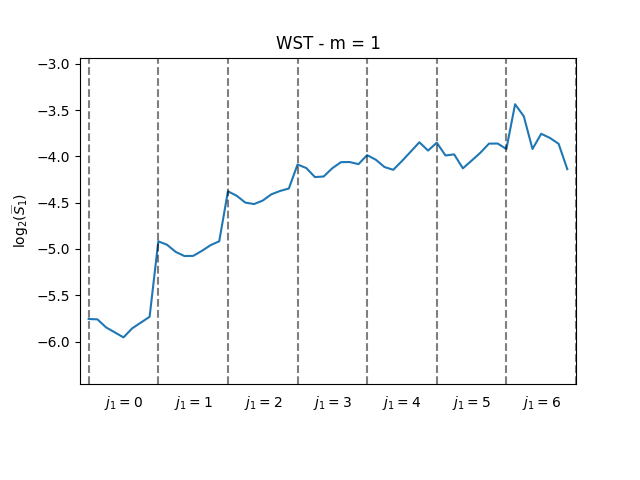

In [15]:
wst.normalize()
mean, _ = wst.get_coeffs(layer=0)
print(mean)
wst.plot(layer=1)

More details on this method can be obtained with the *help* command:

In [16]:
help(wst.normalize)

Help on method normalize in module pywst.wst:

normalize() method of pywst.wst.WST instance
    Normalization of the coefficients.
    
    Layer 0 coefficients are left unchanged.
    Layer 1 coefficients are normalized by layer 0 coefficients (locally if available):
        
    .. math::
        
        \bar{S}_1(j_1,\theta_1) = S_1(j_1,\theta_1)/S_0
        
    Layer 2 coefficients are normalized by the corresponding layer 1 coefficients (locally if available):
        
    .. math::
        
        \bar{S}_2(j_1,\theta_1,j_2,\theta_2) = S_2(j_1,\theta_1,j_2,\theta_2)/S_1(j_1,\theta_1)
    
    Returns
    -------
    None.



**NB:** In general, do not hesitate to use the *help* command to get additional details on the classes/methods of *PyWST*.

Finally, we can check the normalization status or whether or not we have computed logarithmic coefficients as follows:

In [17]:
print(wst.normalized, wst.log2vals)

True True


Note that we can cancel both the normalization and the computation of logarithmic coefficients using *unnormalize* and *to_linear* methods.

### 1.2. One complex map, global WST

To deal with complex maps (such as $Q+iU$ polarization maps), we have to build another WST operator, which computes twice as many wavelet filters as the previous case since we now have to consider *2L* values for $\theta_1$ variable. This can be simply done by adding the *cplx=True* option to *WSTOp* constructor.

Let us show $\log_2(\bar{S}_1)$ coefficients corresponding to the $\tilde{Q}+i\tilde{U}$ test polarization map.

<IPython.core.display.Javascript object>


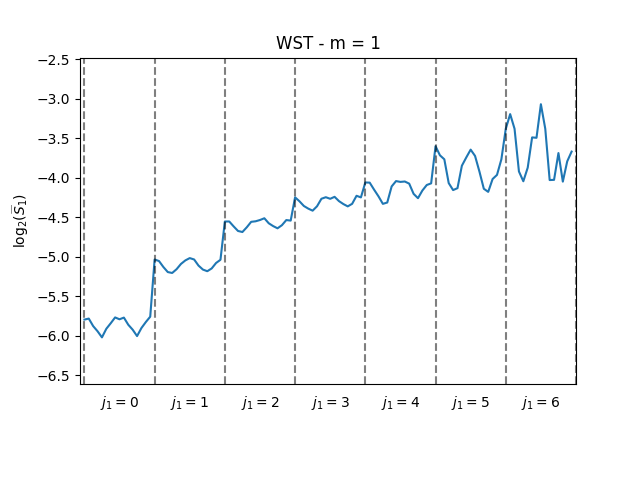

In [18]:
wst_op_cplx = pw.WSTOp(M, N, J, L, OS, cplx=True)

wst_cplx = wst_op_cplx.apply(mapQiU)
wst_cplx.to_log2()
wst_cplx.normalize()
wst_cplx.plot(layer=1)

Except for this additional *cplx=True* parameter, working with complex maps is completely similar to working with real maps. This is why we will only focus on real maps in the following.

### 1.3. One real map, local WST

Computing local WST coefficients consists in computing:

$$
\begin{align}
	&S_0({\bf x}) = I\star\phi_J({\bf x}),\\
	&S_1(j_1,\theta_1)({\bf x}) = |I\star\psi_{j_1, \theta_1}|\star\phi_J({\bf x}),\\
	&S_2 (j_1,\theta_1,j_2,\theta_2)({\bf x}) =  ||I \star \psi_{j_1, \theta_1}|\star\psi_{j_2, \theta_2}|\star\phi_J({\bf x}),
\end{align}
$$
and extracting evenly spaced pixels for each of these maps, whose spacing depends on *J* and *OS* parameters. In practice, the spacing corresponds to keeping one pixel out of $2^{\rm J-OS}$ pixels along each dimension.

Let us compute local WST coefficients on one $I$ map and plot the corresponding $m=1$ coefficients.

<IPython.core.display.Javascript object>


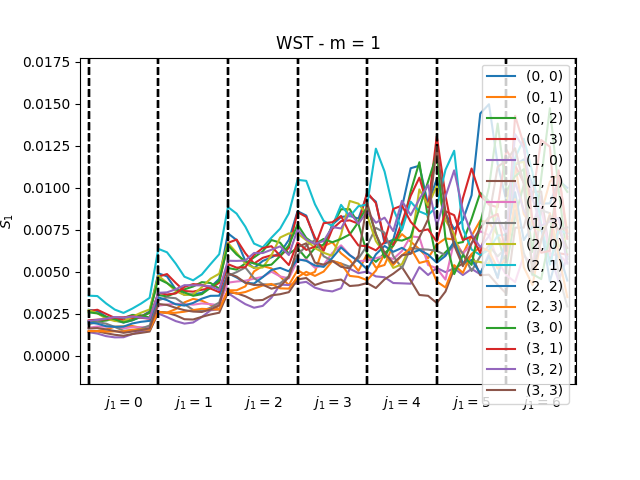

In [19]:
wst = wst_op.apply(mapsI[0], local=True)
wst.plot(layer=1)

On this example, with $512\times512$ pixels maps, *J=7* and *OS=0*, the spatial shape of the output is a $4\times4$ matrix. The legend of the previous plot helps to identify local samples.

When working with maps for which periodic boundary conditions (PBC) are irrelevant, as from observational data, it is necessary to remove the local samples that are close to the boundaries. Indeed, the WST is implemented under PBC assumption in *PyWST*. You can easily ignore these potentially irrelevant local samples using the *crop* option when applying a WST operator to your data. This option tells to discard local samples that are at a distance to the boundaries lower than the specified value, which is expressed as a multiple of $2^J$ pixels.

<IPython.core.display.Javascript object>


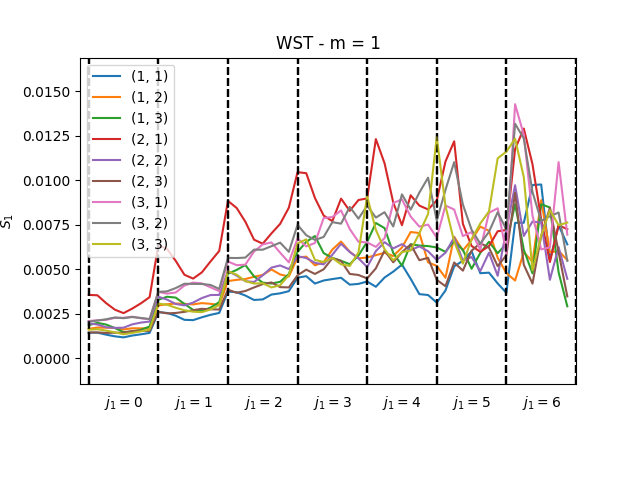

In [20]:
wst = wst_op.apply(mapsI[0], local=True, crop=1)
wst.plot(layer=1)

Cropped samples are masked using NumPy masked arrays:

In [21]:
S0s, _ = wst.get_coeffs(layer=0)

print(S0s)

[[[-- -- -- --]
  [-- 0.08491917826626882 0.0956012849890658 0.10687064831470422]
  [-- 0.1433922027264571 0.09846634562530475 0.09314919816170242]
  [-- 0.12485909759316643 0.13273844654831593 0.09661712811265252]]]


We can average local WST coefficients to compute global ones. This is typically useful to estimate error bars for the global coefficients. This is done using the *average* method.

<IPython.core.display.Javascript object>


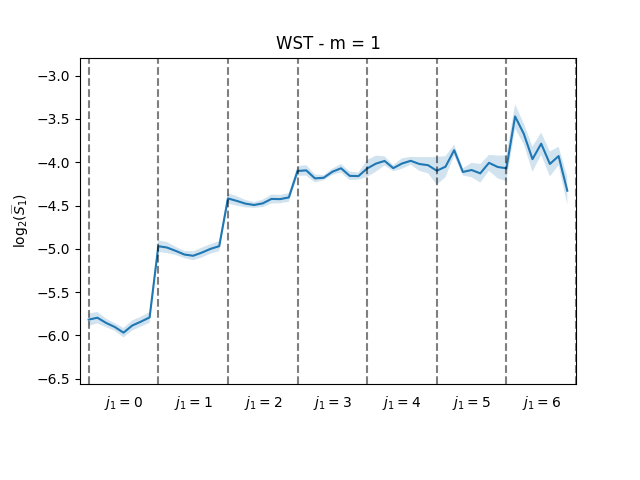

In [22]:
wst.to_log2()
wst.normalize()
wst.average()
wst.plot(layer=1)

We see on this example the error bars corresponding to the mean coefficients.

Actually, when calling *average* method, *PyWST* computes the full covariance matrix associated to the WST coefficients. One can access this matrix using *get_coeffs_cov*, or one can simply extract the corresponding standard deviations using *get_coeffs_std*. Note that standard deviations simply are the square root of the diagonal coefficients of the covariance matrix.

For example let us extract the covariance matrix and the corresponding standard deviations of $m=1$ and $j_1=2$ coefficients.

In [23]:
cov, _ = wst.get_coeffs_cov(layer=1, j1=2)
print(cov)

std, _ = wst.get_coeffs_std(layer=1, j1=2)
print(std)

[[ 3.53071718e-03  3.16223175e-03  1.96066676e-03  3.65502424e-04
   3.74488018e-05  3.94528740e-04  1.40733325e-03  2.81169994e-03]
 [ 3.16223175e-03  3.05321099e-03  2.11478532e-03  3.52362977e-04
  -2.25869049e-04  6.44208129e-05  1.08541793e-03  2.54345341e-03]
 [ 1.96066676e-03  2.11478532e-03  1.82771291e-03  4.73256280e-04
  -1.96697661e-04 -8.29981465e-05  5.37117254e-04  1.60295052e-03]
 [ 3.65502424e-04  3.52362977e-04  4.73256280e-04  1.09642303e-03
   1.18610080e-03  1.17210589e-03  9.05100054e-04  4.34572488e-04]
 [ 3.74488018e-05 -2.25869049e-04 -1.96697661e-04  1.18610080e-03
   1.85503601e-03  1.99669702e-03  1.37602291e-03  2.47361862e-04]
 [ 3.94528740e-04  6.44208129e-05 -8.29981465e-05  1.17210589e-03
   1.99669702e-03  2.70350381e-03  2.16122299e-03  7.40933844e-04]
 [ 1.40733325e-03  1.08541793e-03  5.37117254e-04  9.05100054e-04
   1.37602291e-03  2.16122299e-03  2.33324308e-03  1.56197657e-03]
 [ 2.81169994e-03  2.54345341e-03  1.60295052e-03  4.34572488e-04
   

### 1.4. Multiple real maps, global WST

Finally, one last important point when performing WST/RWST analyses is the concept of *batches*. When working with a set of maps that are meant to be analyzed as a whole, one can gather these maps in a batch of images, which simply is a 3D array where the first dimension corresponds to the map index. This can be useful to enhance the estimation of WST coefficients by increasing the amount of samples, or to speed up the computation of the WST of a large amount of maps.

For example, in **Regaldo-Saint Blancard+2020**, we use batches to gather several outputs of a MHD simulation and to analyze the mean statistics of the simulation through their mean WST coefficients.

In the following, we compute the mean WST statistics corresponding to our batch of 3 $I$ maps:

<IPython.core.display.Javascript object>


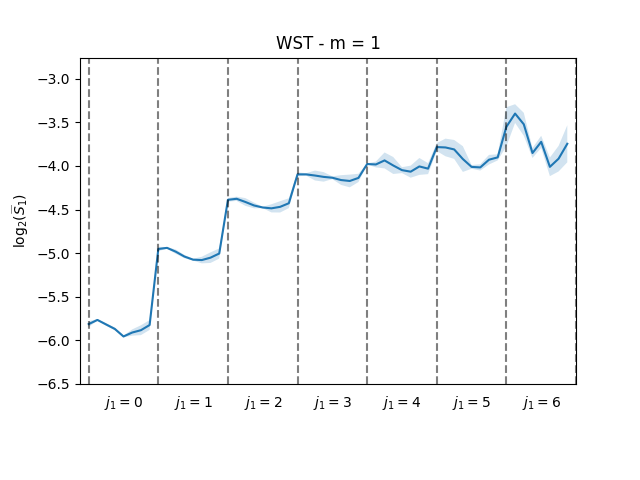

In [24]:
wst_batch = wst_op.apply(mapsI)
wst_batch.to_log2()
wst_batch.normalize()
wst_batch.average()
wst_batch.plot(layer=1)

# 2. RSWT computation

We now want to compute and show the RWST statistics of our test data.

The RWST corresponds to a model of the angular dependencies of the WST coefficients. We will see in this section how to compute RWST coefficients straight from data, as well as from *WST* objects.

The regular RWST model is a model of the angular dependencies of the logarithm of the WST coefficients (typically normalized coefficients) for $m=1$ and $m=2$. We remind this model:
$$
\begin{align}
&\log_2\left[\bar{S}_1\left(j_1, \theta_1\right)\right] = \hat{S}_1^{\mathrm{iso}}(j_1) +\hat{S}_1^{\mathrm{aniso}}(j_1)\cos\left(2\left[\theta_1 - \theta^{\mathrm{ref}, 1}\left(j_1\right)\right]\right)\\
&\log_2  \left[ \bar{S}_2 \left(j_1, \theta_1, j_2, \theta_2\right)\right] =\hat{S}_2^{\mathrm{iso}, 1}(j_1, j_2) +  \hat{S}_2^{\mathrm{iso}, 2}(j_1, j_2)\cos\left(2\left[\theta_1 - \theta_2\right]\right) +  \hat{S}_2^{\mathrm{aniso},1}(j_1, j_2)\cos\left(2\left[\theta_1 - \theta^{\mathrm{ref}, 2}\left(j_1, j_2\right)\right]\right) + \hat{S}_2^{\mathrm{aniso},2}(j_1, j_2)\cos\left(2\left[\theta_2- \theta^{\mathrm{ref}, 2}\left(j_1, j_2\right)\right]\right)
\end{align}
$$
This is the default model implemented in *PyWST*.

###  2.1. RWST computation from a real intensity map

In the same way as WST analyses, we can compute RWST coefficients both globally and locally.

Let us first see how to compute the global RWST coefficients based on the default RWST model from a real intensity map.

To do that, we need to build an RWST operator, which is an instance of the *RWSTOp* class, and then to apply this operator to our data.

In [25]:
rwst_op = pw.RWSTOp(M, N, J, L, OS)
rwst = rwst_op.apply(mapsI[0])

The syntax is identical to what we did when performing WST analyses. The *apply* methods returns a *RWST* object.

**NB:** By default, a *RWSTOp* object creates a *WSTOp* object. If we have already built a *WSTOp* object, it is possible to give it to the *RWSTOp* constructor using the optional *wst_op* parameter. This avoids redundant computations.

We can get some information related to the RWST model bound to the *rwst* variable:

In [26]:
print(rwst.model)

Model: RWSTModel1
--> Layer 0 coefficient: S0
--> Layer 1 coefficients: S1Iso - S1Aniso - ThetaRef1
--> Layer 2 coefficients: S2Iso1 - S2Iso2 - S2Aniso1 - S2Aniso2 - ThetaRef2


Then, it is easy to plot some RWST coefficients, for example the layer 2 isotropic ones:

<IPython.core.display.Javascript object>


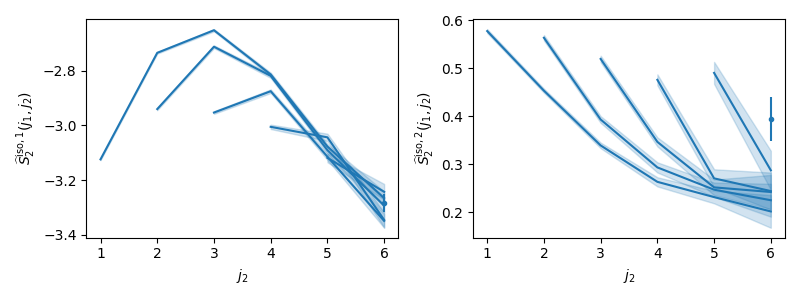

In [27]:
rwst.plot(["S2Iso1", "S2Iso2"])

We can also directly access the coefficients and their corresponding error bars:

In [28]:
# There is one coefficient per j1 value
print(rwst.get_coeffs("S1Iso"))
print(rwst.get_coeffs_std("S1Iso"))

[-5.82568189 -4.9938135  -4.42738909 -4.12299329 -4.00765812 -3.95939348
 -3.79954237]
[0.0081077  0.00175875 0.00321667 0.01068868 0.01146042 0.01472217
 0.07236622]


###  2.2. RWST computation from a batch of maps

We can also compute RWST coefficients from a batch of maps.

In [29]:
rwst_batch = rwst_op.apply(mapsI)

<IPython.core.display.Javascript object>


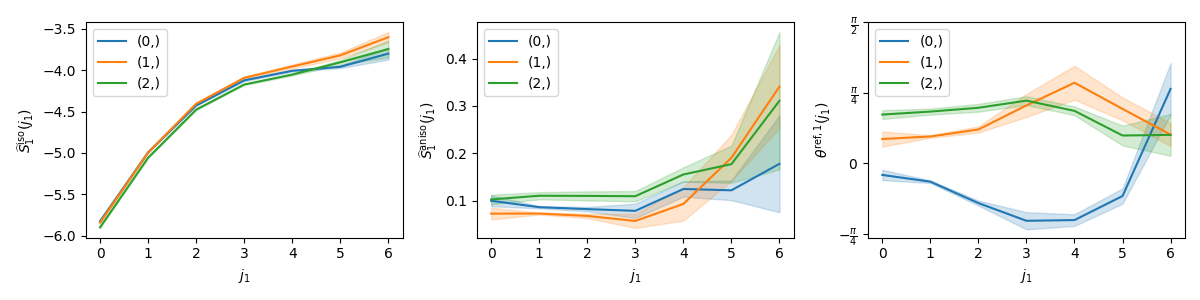

In [30]:
rwst_batch.plot(["S1Iso", "S1Aniso", "ThetaRef1"])

**NB:** We can compute RWST coefficients from the mean WST statistics fo the batch adding *wst_average=True* when calling *apply* method.

###  2.3. RWST computation from WST coefficients

We can also compute the RWST coefficients from a WST object. Let us reuse the *wst_batch* variable defined in Section 1.4 and compute RWST coefficients from it:

In [31]:
rwst_batch = rwst_op.apply(wst_batch)

Let us plot all the RWST coefficients as well as the $\chi^2_{\rm r}$ values associated to the fits, by calling *plot* method without any parameter.

<IPython.core.display.Javascript object>


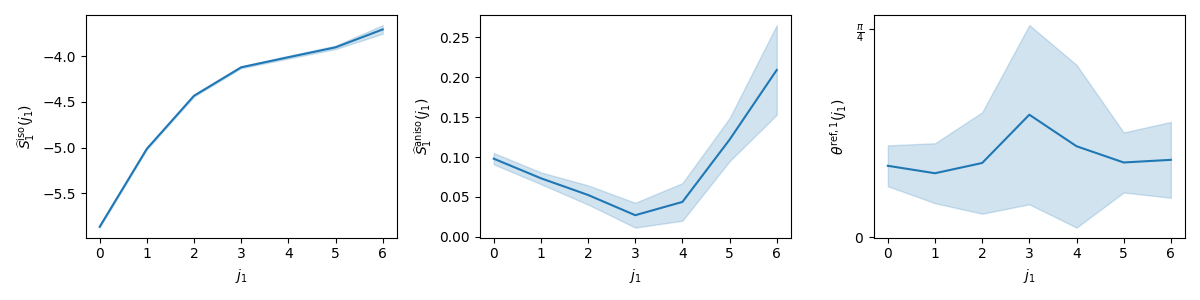

<IPython.core.display.Javascript object>


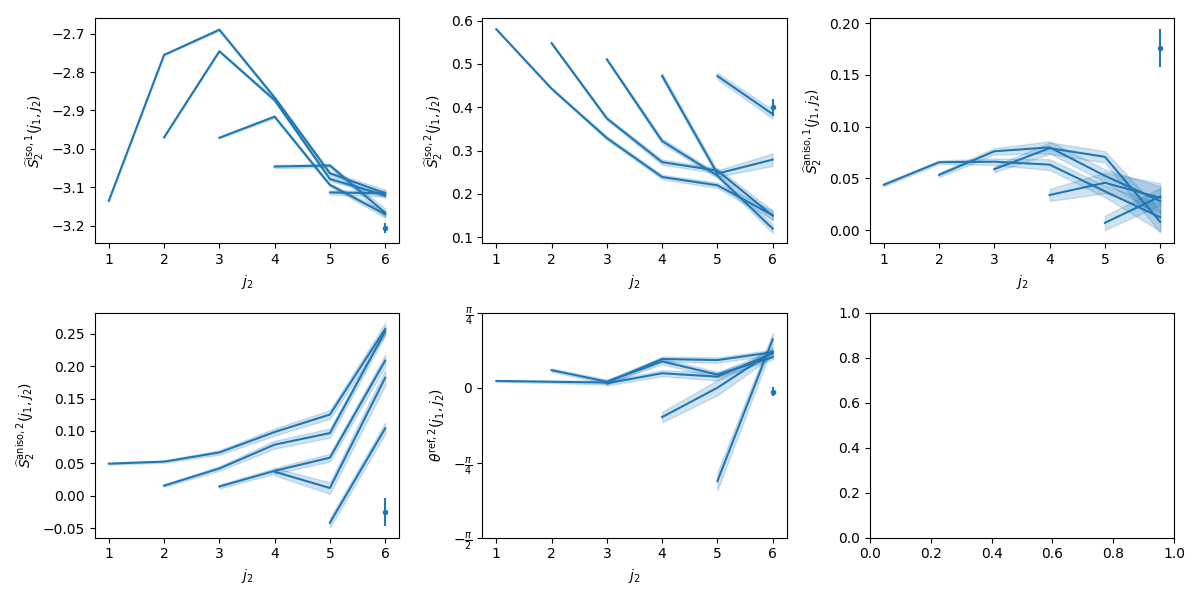

<IPython.core.display.Javascript object>


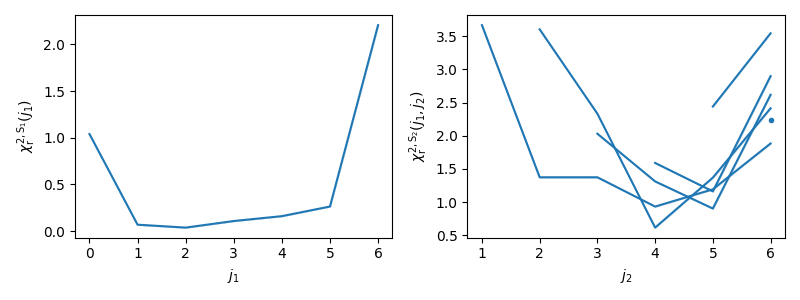

In [32]:
rwst_batch.plot()

**NB:** By default, the RWST fits take into account the standard deviations of the WST coeffficients if they exist, but if the covariance matrix is also well estimated, we can use the full covariance matrix for the fits setting *diag_cov=False* when calling *apply* method.

### 2.2. Local RWST computation

In the same way as WST analyses, RWST coefficients can be computed locally:

In [33]:
rwst = rwst_op.apply(mapsI[0], local=True, crop=1.0)

<IPython.core.display.Javascript object>


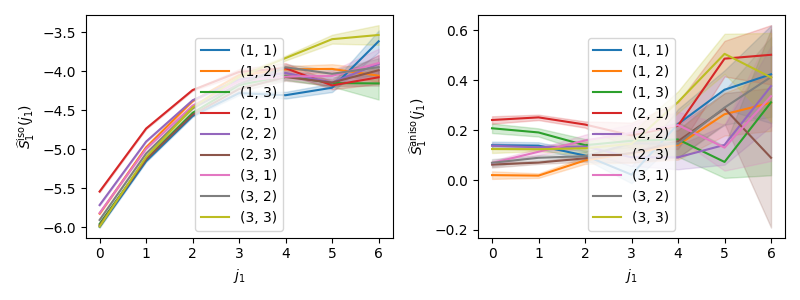

In [34]:
rwst.plot(["S1Iso", "S1Aniso"])

### 2.3. Changing the RWST model

Finally, we can easily use another RWST model when defining an RWST operator through the *model_cls* option.

In *PyWST*, an RWST model is a child class of *RWSTModelBase* class. The package includes two standard models: *RWSTModel1* (default model) and *RWSTModel2*.

For example let us use the *RWSTModel2* in the following. This model corresponds to the *RWSTModel1* model complemented by additional terms related to higher harmonics of the angular dependencies:
$$
\begin{align}
&\log_2\left[\bar{S}_1\left(j_1, \theta_1\right)\right] = \cdots + \hat{S}_1^{\mathrm{lat}, 1}(j_1)\cos\left(4\theta_1\right) + \hat{S}_1^{\mathrm{lat}, 2}(j_1)\cos\left(8\theta_1\right)\\
&\log_2  \left[ \bar{S}_2 \left(j_1, \theta_1, j_2, \theta_2\right)\right] = \cdots + \hat{S}_2^{\mathrm{iso}, 3}(j_1, j_2)\cos\left(4\left[\theta_1 - \theta_2\right]\right)
\end{align}
$$



In [35]:
rwst_op_model2 = pw.RWSTOp(M, N, J, L, wst_op=wst_op, model_cls=pw.RWSTModel2)
rwst = rwst_op_model2.apply(mapsI[0], local=True, crop=1.0)
print(rwst.model)

Model: RWSTModel2
--> Layer 0 coefficient: S0
--> Layer 1 coefficients: S1Iso - S1Aniso - ThetaRef1 - S1Lat1 - S1Lat2
--> Layer 2 coefficients: S2Iso1 - S2Iso2 - S2Aniso1 - S2Aniso2 - ThetaRef2 - S2Iso3


Let us plot a few coefficients of this model:

<IPython.core.display.Javascript object>


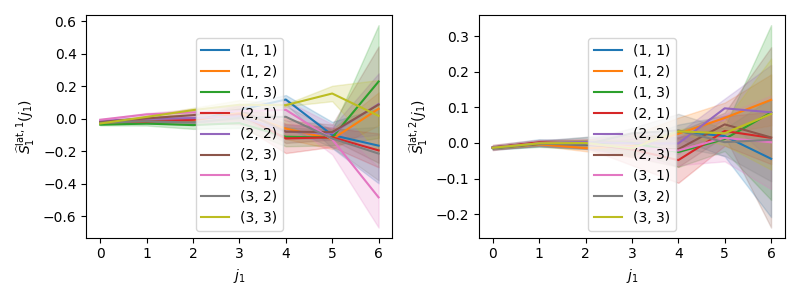

In [36]:
rwst.plot(['S1Lat1', 'S1Lat2'])

**NB:** We can easily define our own RWST model by defining a custom child class of the *RWSTModelBase* class.

## 3. Comparison of (R)WST statistics

WST and RWST statistics can be compared with the *plot_compare* method, defined for both *WST* and *RWST* objects.

For example let us compare some WST statistics with its RWST corresponding modelization.

<IPython.core.display.Javascript object>


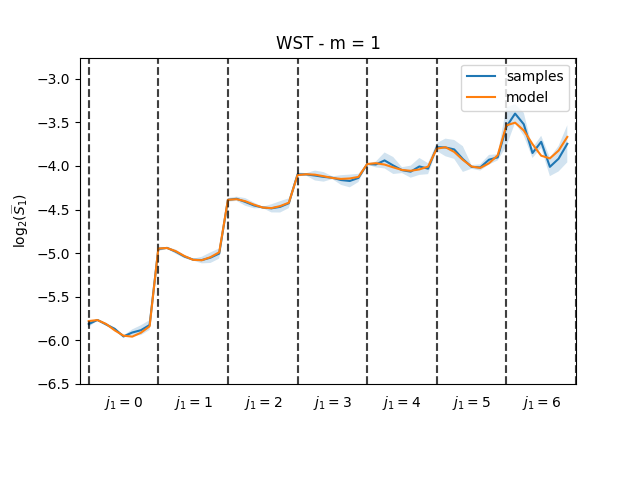

In [37]:
wst_batch.plot_compare(rwst_batch, layer=1, labels=['samples', 'model'])

One can also compare RWST coefficients with each other as follows:

<IPython.core.display.Javascript object>


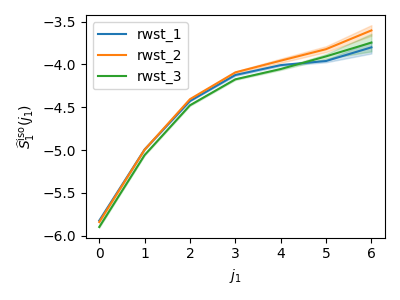

In [38]:
rwst_1 = rwst_op.apply(mapsI[0])
rwst_2 = rwst_op.apply(mapsI[1])
rwst_3 = rwst_op.apply(mapsI[2])

rwst_1.plot_compare([rwst_2, rwst_3], "S1Iso", labels=["rwst_1", "rwst_2", "rwst_3"])

## 4. Playing with filters

Finally we give in this Section some examples to visualize the filters that are essential when computing WST coefficients.

In [39]:
def plot_filter(data):
    data = np.fft.fftshift(data) # Centering of the filter
    fig, axs = plt.subplots(1, 2, figsize=(10,3))
    plot_axis(fig, axs[0], data.real, "Real part")
    plot_axis(fig, axs[1], data.imag, "Imaginary part")
    plt.show()
    
# This disables a warning for the next plots.
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 25

### 4.1. Gaussian filters

Mean: 3.814697265625e-06 
L1-norm: 1.0


<IPython.core.display.Javascript object>


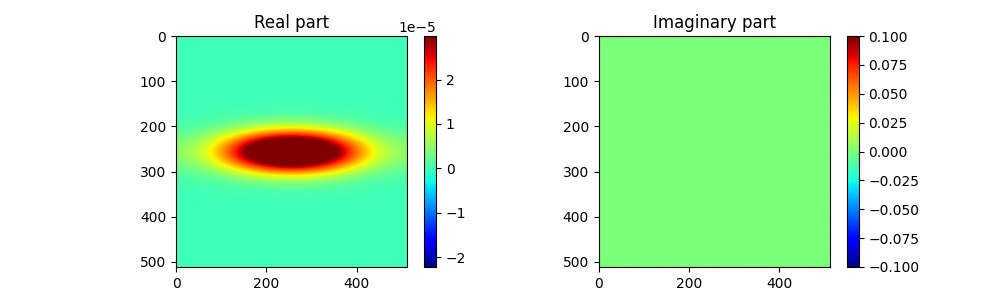

In [40]:
gaussian = pw.GaussianFilter(M, N, 5, gamma=0.3)
print ("Mean:", gaussian.data.mean(), "\nL1-norm:", np.sum(np.absolute(gaussian.data)))
plot_filter(gaussian.data)

### 4.2. Morlet wavelets

Mean: (-2.6469779601696886e-23-1.9025154088719637e-23j) 
L1-norm: 0.9785959280063218


<IPython.core.display.Javascript object>


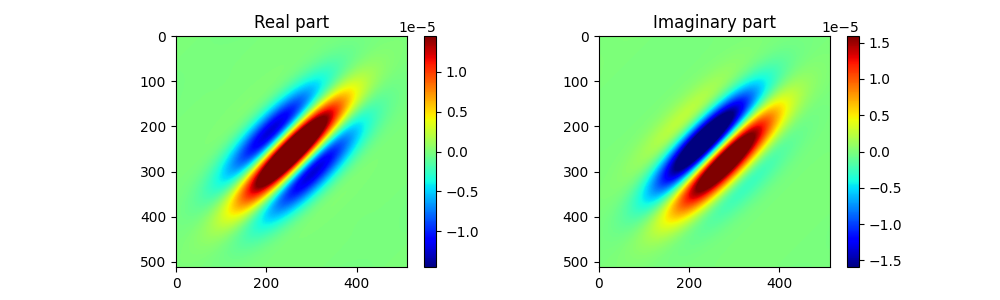

In [41]:
morlet = pw.MorletWavelet(M, N, 6, np.pi/4, 0.5, sigma0=0.8, k0=3*np.pi/4)
print("Mean:", morlet.data.mean(), "\nL1-norm:", np.sum(np.absolute(morlet.data)))
plot_filter(morlet.data)